# SMS spam classification by using SimpleRNN

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
df = pd.read_csv('spam.csv', encoding = 'latin1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


## Preprocessing

In [5]:
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)


In [6]:
df['v1'] = df.v1.replace(['ham', 'spam'], [0, 1])
df

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [7]:
df.isnull().sum()

v1    0
v2    0
dtype: int64

### Delete overlapped data

In [8]:
df.v2.nunique() # 중복 여부

5169

In [9]:
df = df.drop_duplicates('v2', keep = 'first')   # 중복 제거

In [10]:
df.v1.value_counts()

0    4516
1     653
Name: v1, dtype: int64

In [11]:
X_data = df.v2.values
y_data = df.v1.values
len(X_data), y_data.shape

(5169, (5169,))

### Delete punctuations and transfer to small letter

In [12]:
from string import punctuation

def prepro(s) :
    s = s.encode('utf8').decode('ascii', 'ignore')
    return ''.join(i for i in s if i not in punctuation).lower()

In [13]:
X_data = [prepro(s) for s in X_data]
X_data[:5]

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat',
 'ok lar joking wif u oni',
 'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s',
 'u dun say so early hor u c already then say',
 'nah i dont think he goes to usf he lives around here though']

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

### Generating word set and checking its size

In [15]:
t = Tokenizer()
t.fit_on_texts(X_data)
vocab_size = len(t.word_index) + 1
vocab_size

9480

In [16]:
sequences = t.texts_to_sequences(X_data)
sequences[0]

[43,
 410,
 3836,
 729,
 663,
 699,
 65,
 8,
 1138,
 93,
 118,
 459,
 1139,
 146,
 2565,
 1140,
 68,
 56,
 3837,
 133]

### Padding

In [17]:
max_len = max(len(i) for i in sequences)
max_len

171

In [18]:
data = pad_sequences(sequences, maxlen = max_len)
data.shape

(5169, 171)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, y_data, stratify = y_data, test_size = 0.2, random_state = seed
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4135, 171), (1034, 171), (4135,), (1034,))

## Processing

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

In [21]:
model = Sequential([
    Embedding(vocab_size, 32, input_length = max_len),
    SimpleRNN(32),
    Dense(1, activation = 'sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 171, 32)           303360    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 305,473
Trainable params: 305,473
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [23]:
history = model.fit(X_train, y_train, epochs = 10, batch_size = 60, validation_split = 0.2)

Epoch 1/10
56/56 [==============================] - 4s 47ms/step - loss: 0.4089 - accuracy: 0.8643 - val_loss: 0.3347 - val_accuracy: 0.8948
Epoch 2/10
56/56 [==============================] - 2s 43ms/step - loss: 0.1725 - accuracy: 0.9550 - val_loss: 0.0915 - val_accuracy: 0.9794
Epoch 3/10
56/56 [==============================] - 2s 43ms/step - loss: 0.0737 - accuracy: 0.9813 - val_loss: 0.0760 - val_accuracy: 0.9819
Epoch 4/10
56/56 [==============================] - 2s 42ms/step - loss: 0.0366 - accuracy: 0.9918 - val_loss: 0.0643 - val_accuracy: 0.9831
Epoch 5/10
56/56 [==============================] - 2s 43ms/step - loss: 0.0167 - accuracy: 0.9979 - val_loss: 0.0666 - val_accuracy: 0.9843
Epoch 6/10
56/56 [==============================] - 2s 42ms/step - loss: 0.0101 - accuracy: 0.9988 - val_loss: 0.0664 - val_accuracy: 0.9843
Epoch 7/10
56/56 [==============================] - 2s 42ms/step - loss: 0.0095 - accuracy: 0.9985 - val_loss: 0.0662 - val_accuracy: 0.9843
Epoch 8/10
56

In [24]:
model.evaluate(X_test, y_test)

33/33 [==============================] - 0s 9ms/step - loss: 0.1072 - accuracy: 0.9623


[0.1072002574801445, 0.9622824192047119]

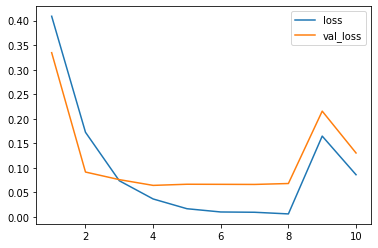

In [27]:
y_loss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = range(1, len(y_loss) + 1)
plt.plot(x_len, y_loss, label = 'loss')
plt.plot(x_len, y_vloss, label = 'val_loss')
plt.legend()
plt.show()